In [1]:
from pathlib import Path

import geopandas
import geopandas as gpd
import pandas
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# TODO other cities?
# TODO whole overlapping period?

# U for Uber, T for T4c, O for OpenStreetMap
UBASEPATH = Path("/iarai/public/t4c/uber")
TBASEPATH = Path("/iarai/public/t4c/data_pipeline/release20221028_historic_uber")
OBASEPATH = Path("/iarai/public/t4c/osm")
CITY = "london"
DAYTIME_START_HOUR = 8
DAYTIME_END_HOUR = 18
DAYTIME_HOURS = DAYTIME_END_HOUR - DAYTIME_START_HOUR

In [2]:
gen_gpkg = True

In [3]:
highway_ordering = [
    "motorway",
    "motorway_link",
    "trunk",
    "trunk_link",
    "primary",
    "primary_link",
    "secondary",
    "secondary_link",
    "tertiary",
    "tertiary_link",
    "unclassified",
    "residential",
    "living_street",
    "service",
    "cycleway",
    "road",
    "construction",
]

In [4]:
plt.rcParams["axes.labelsize"] = 24

In [5]:
# simplified_filter = lambda hw: hw not in ['residential', 'living_street', 'service', 'road']
simplified_filter = lambda hw: hw in [
    "motorway",
    "motorway_link",
    "trunk",
    "trunk_link",
    "primary",
    "primary_link",
    "secondary",
    "secondary_link",
    "tertiary",
    "tertiary_link",
]

In [6]:
def osm_color_palette():
    for c in ["#e892a2", "#e892a2", "#f9b29c", "#f9b29c", "#fcd6a4", "#fcd6a4", "#f7fabf", "#f7fabf"] + ["white"] * 99:
        yield c

## Load Uber segment speeds

In [7]:
# uspeeds_df = pandas.read_csv(UBASEPATH / 'movement-speeds-hourly-madrid-2020-3.csv')
# uspeeds_df = pandas.read_csv(UBASEPATH / 'movement-speeds-hourly-london-2019-10.csv')
uspeeds_df = pandas.read_parquet(UBASEPATH / "movement-speeds-hourly-london-2019-10.parquet")
uspeeds_df["speed_kph_mean"] = uspeeds_df["speed_mph_mean"] * 1.60934
uspeeds_df = uspeeds_df.rename(columns={"osm_start_node_id": "u", "osm_end_node_id": "v", "osm_way_id": "osmid"})
uspeeds_df["gkey"] = [f"{u}_{v}_{osmid}" for u, v, osmid in zip(uspeeds_df["u"], uspeeds_df["v"], uspeeds_df["osmid"])]
uspeeds_df

,u,v,osmid,year,month,day,hour,speed_mph_mean,speed_mph_stddev,speed_kph_mean,gkey
0,6504105337,1604745704,147247974,2019,10,9,18,18.752,3.781,30.178344,6504105337_1604745704_147247974
1,6504105337,1604745704,147247974,2019,10,9,15,19.461,4.255,31.319366,6504105337_1604745704_147247974
2,6504105337,1604745704,147247974,2019,10,8,18,13.603,4.862,21.891852,6504105337_1604745704_147247974
3,6504105337,1604745704,147247974,2019,10,8,16,15.450,2.076,24.864303,6504105337_1604745704_147247974
4,6504105337,1604745704,147247974,2019,10,8,15,17.119,2.450,27.550291,6504105337_1604745704_147247974
...,...,...,...,...,...,...,...,...,...,...,...
47121785,4804443645,3863127062,688989358,2019,10,21,19,14.349,4.693,23.092420,4804443645_3863127062_688989358
47121786,4804443645,3863127062,688989358,2019,10,14,8,12.321,4.213,19.828678,4804443645_3863127062_688989358
47121787,4804443645,3863127062,688989358,2019,10,4,8,12.269,4.079,19.744992,4804443645_3863127062_688989358
47121788,4804443645,3863127062,688989358,2019,10,7,8,13.596,7.274,21.880587,4804443645_3863127062_688989358


## Load our segment speeds

In [8]:
tspeeds_l = []
for i in range(21, 28):
    f = TBASEPATH / "speed_classes" / "london" / f"speed_classes_2019-10-{i}.parquet"
    print(f)
    df = pd.read_parquet(f)
    df["date"] = df["day"]
    df["year"] = 2019
    df["month"] = 10
    df["day"] = i
    df["hour"] = df["t"] // 4
    df = (
        df[["u", "v", "gkey", "year", "month", "day", "hour", "volume_class", "volume", "median_speed_kph", "free_flow_kph"]]
        .groupby(by=["u", "v", "gkey", "year", "month", "day", "hour"])
        .mean()
        .reset_index()
    )
    tspeeds_l.append(df)
tspeeds_df = pandas.concat(tspeeds_l)
# tspeeds_df = tspeeds_df.rename(columns={'osmid': 'osm_way_id'})
tspeeds_df

/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-21.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-22.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-23.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-24.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-25.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-26.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-27.parquet


,u,v,gkey,year,month,day,hour,volume_class,volume,median_speed_kph,free_flow_kph
0,78112,25508583,78112_25508583_129375498,2019,10,21,7,3.000000,3.0,19.411765,45.176471
1,78112,25508583,78112_25508583_129375498,2019,10,21,8,4.000000,11.5,44.588235,45.176471
2,78112,25508583,78112_25508583_129375498,2019,10,21,9,2.000000,2.5,45.176471,45.176471
3,78112,25508583,78112_25508583_129375498,2019,10,21,10,4.333333,6.0,42.823529,45.176471
4,78112,25508583,78112_25508583_129375498,2019,10,21,11,4.000000,6.5,26.705882,45.176471
...,...,...,...,...,...,...,...,...,...,...,...
1380556,6577745911,5930672687,6577745911_5930672687_646234311,2019,10,27,16,1.000000,2.0,52.705882,47.294118
1380557,6577745911,5930672687,6577745911_5930672687_646234311,2019,10,27,18,3.000000,3.0,37.176471,47.294118
1380558,6577745911,5930672687,6577745911_5930672687_646234311,2019,10,27,20,1.000000,2.0,42.352941,47.294118
1380559,6577745911,5930672687,6577745911_5930672687_646234311,2019,10,27,22,1.000000,2.0,56.705882,47.294118


In [9]:
u_ids = set(zip(uspeeds_df["u"], uspeeds_df["v"], uspeeds_df["gkey"]))
u_ids

{(128681934, 4949746851, '128681934_4949746851_13802540'),
 (471427824, 319105322, '471427824_319105322_561591937'),
 (110016, 25473491, '110016_25473491_222301969'),
 (3318142673, 3318142676, '3318142673_3318142676_685731910'),
 (23045973, 282499823, '23045973_282499823_153973176'),
 (27460250, 27331469, '27460250_27331469_4479133'),
 (6292288163, 6292288161, '6292288163_6292288161_38103818'),
 (1187244955, 27055800, '1187244955_27055800_5027479'),
 (61967675, 149311535, '61967675_149311535_25755925'),
 (2132520508, 32960295, '2132520508_32960295_4974206'),
 (4636409509, 102071, '4636409509_102071_642911647'),
 (308941254, 7615674, '308941254_7615674_3325856'),
 (27788788, 27789881, '27788788_27789881_156616452'),
 (13808476, 1811868251, '13808476_1811868251_2954315'),
 (304403104, 6277846712, '304403104_6277846712_8227706'),
 (15887843, 1640252027, '15887843_1640252027_169872563'),
 (18221106, 18221107, '18221106_18221107_3675330'),
 (4202795060, 4202795061, '4202795060_4202795061_54

In [10]:
t_ids = set(zip(tspeeds_df["u"], tspeeds_df["v"], tspeeds_df["gkey"]))
t_ids

{(128681934, 4949746851, '128681934_4949746851_13802540'),
 (230083521, 230083523, '230083521_230083523_223963599'),
 (390085923, 31193354, '390085923_31193354_4843402'),
 (471427824, 319105322, '471427824_319105322_561591937'),
 (108329417, 122671186, '108329417_122671186_98222517'),
 (149263842, 149251551, '149263842_149251551_24877598'),
 (110016, 25473491, '110016_25473491_222301969'),
 (27460250, 27331469, '27460250_27331469_4479133'),
 (2060681157, 296379, '2060681157_296379_39441046'),
 (6292288163, 6292288161, '6292288163_6292288161_38103818'),
 (25810228, 25810690, '25810228_25810690_636345330'),
 (61967675, 149311535, '61967675_149311535_25755925'),
 (1187244955, 27055800, '1187244955_27055800_5027479'),
 (4636409509, 102071, '4636409509_102071_642911647'),
 (108428, 106855, '108428_106855_82965239'),
 (82747166, 26835962, '82747166_26835962_585789620'),
 (480125, 209125, '480125_209125_2402128'),
 (27788788, 27789881, '27788788_27789881_156616452'),
 (13808476, 1811868251, '

In [11]:
assert t_ids.issubset(u_ids)

In [12]:
# for u,v in u_uv - t_uv:
#     print(f"https://www.openstreetmap.org/node/{u}")
#     print(f"https://www.openstreetmap.org/node/{v}")
#     break

## Restrict to daytime only

In [13]:
tspeeds_df = tspeeds_df[(tspeeds_df["hour"] >= DAYTIME_START_HOUR) & (tspeeds_df["hour"] < DAYTIME_END_HOUR)]
tspeeds_df

,u,v,gkey,year,month,day,hour,volume_class,volume,median_speed_kph,free_flow_kph
1,78112,25508583,78112_25508583_129375498,2019,10,21,8,4.000000,11.5,44.588235,45.176471
2,78112,25508583,78112_25508583_129375498,2019,10,21,9,2.000000,2.5,45.176471,45.176471
3,78112,25508583,78112_25508583_129375498,2019,10,21,10,4.333333,6.0,42.823529,45.176471
4,78112,25508583,78112_25508583_129375498,2019,10,21,11,4.000000,6.5,26.705882,45.176471
5,78112,25508583,78112_25508583_129375498,2019,10,21,12,1.000000,2.0,36.705882,45.176471
...,...,...,...,...,...,...,...,...,...,...,...
1380552,6577745911,5930672687,6577745911_5930672687_646234311,2019,10,27,12,1.000000,2.0,53.647059,47.294118
1380553,6577745911,5930672687,6577745911_5930672687_646234311,2019,10,27,13,2.000000,2.5,45.000000,47.294118
1380554,6577745911,5930672687,6577745911_5930672687_646234311,2019,10,27,14,3.666667,5.0,45.607843,47.294118
1380555,6577745911,5930672687,6577745911_5930672687_646234311,2019,10,27,15,1.000000,2.0,46.588235,47.294118


In [14]:
uspeeds_df = uspeeds_df[(uspeeds_df["hour"] >= DAYTIME_START_HOUR) & (uspeeds_df["hour"] < DAYTIME_END_HOUR)]
uspeeds_df

,u,v,osmid,year,month,day,hour,speed_mph_mean,speed_mph_stddev,speed_kph_mean,gkey
1,6504105337,1604745704,147247974,2019,10,9,15,19.461,4.255,31.319366,6504105337_1604745704_147247974
3,6504105337,1604745704,147247974,2019,10,8,16,15.450,2.076,24.864303,6504105337_1604745704_147247974
4,6504105337,1604745704,147247974,2019,10,8,15,17.119,2.450,27.550291,6504105337_1604745704_147247974
5,6504105337,1604745704,147247974,2019,10,8,17,17.378,2.898,27.967111,6504105337_1604745704_147247974
6,6504105346,1604745704,147247978,2019,10,8,16,20.766,2.045,33.419554,6504105346_1604745704_147247978
...,...,...,...,...,...,...,...,...,...,...,...
47121782,4804443645,3863127062,688989358,2019,10,28,8,15.863,4.316,25.528960,4804443645_3863127062_688989358
47121784,4804443645,3863127062,688989358,2019,10,2,8,13.001,3.836,20.923029,4804443645_3863127062_688989358
47121786,4804443645,3863127062,688989358,2019,10,14,8,12.321,4.213,19.828678,4804443645_3863127062_688989358
47121787,4804443645,3863127062,688989358,2019,10,4,8,12.269,4.079,19.744992,4804443645_3863127062_688989358


## Counts/densityfor both

In [15]:
ucounts = uspeeds_df.groupby(["u", "v", "gkey"]).agg(count=("speed_kph_mean", "count"), speed_kph_mean=("speed_kph_mean", "first")).reset_index()
ucounts

,u,v,gkey,count,speed_kph_mean
0,78112,25508583,78112_25508583_129375498,310,15.745783
1,78112,25508584,78112_25508584_129375498,298,42.074585
2,99936,2146383887,99936_2146383887_204647020,1,18.505801
3,99936,4544836433,99936_4544836433_233623258,300,12.419277
4,99937,200047,99937_200047_4257261,228,4.578572
...,...,...,...,...,...
210797,6577730921,2379175,6577730921_2379175_358627524,204,20.729909
210798,6577730921,254761207,6577730921_254761207_358627524,291,17.565946
210799,6577730928,2379175,6577730928_2379175_700435511,21,11.276645
210800,6577745911,36728211,6577745911_36728211_646234311,103,45.056692


In [16]:
tcounts = (
    tspeeds_df.groupby(["u", "v", "gkey"])
    .agg(count=("median_speed_kph", "count"), median_speed_kph=("median_speed_kph", "first"), mean_volume=("volume", "mean"))
    .reset_index()[["u", "v", "gkey", "count", "median_speed_kph", "mean_volume"]]
)
tcounts

,u,v,gkey,count,median_speed_kph,mean_volume
0,78112,25508583,78112_25508583_129375498,56,44.588235,5.572917
1,78112,25508584,78112_25508584_129375498,49,32.941176,5.814626
2,99936,2146383887,99936_2146383887_204647020,70,20.450980,6.802381
3,99936,4544836433,99936_4544836433_233623258,70,15.784314,9.896429
4,99937,200047,99937_200047_4257261,70,10.852941,26.415476
...,...,...,...,...,...,...
136120,6577730921,254761207,6577730921_254761207_358627524,52,19.705882,4.432692
136121,6577730921,6577730928,6577730921_6577730928_8227762,44,15.235294,4.259470
136122,6577730928,2379175,6577730928_2379175_700435511,50,33.647059,4.633333
136123,6577745911,36728211,6577745911_36728211_646234311,60,44.235294,3.675000


In [17]:
num_slots_t_speeds = len(set(zip(tspeeds_df["year"], tspeeds_df["month"], tspeeds_df["day"], tspeeds_df["hour"])))
num_slots_t_speeds

70

In [18]:
num_slots_t_speeds / DAYTIME_HOURS

7.0

In [19]:
assert num_slots_t_speeds % DAYTIME_HOURS == 0

In [20]:
tcounts["density"] = tcounts["count"] / num_slots_t_speeds
tcounts

,u,v,gkey,count,median_speed_kph,mean_volume,density
0,78112,25508583,78112_25508583_129375498,56,44.588235,5.572917,0.800000
1,78112,25508584,78112_25508584_129375498,49,32.941176,5.814626,0.700000
2,99936,2146383887,99936_2146383887_204647020,70,20.450980,6.802381,1.000000
3,99936,4544836433,99936_4544836433_233623258,70,15.784314,9.896429,1.000000
4,99937,200047,99937_200047_4257261,70,10.852941,26.415476,1.000000
...,...,...,...,...,...,...,...
136120,6577730921,254761207,6577730921_254761207_358627524,52,19.705882,4.432692,0.742857
136121,6577730921,6577730928,6577730921_6577730928_8227762,44,15.235294,4.259470,0.628571
136122,6577730928,2379175,6577730928_2379175_700435511,50,33.647059,4.633333,0.714286
136123,6577745911,36728211,6577745911_36728211_646234311,60,44.235294,3.675000,0.857143


In [21]:
len(tcounts)

136125

In [22]:
(tcounts["count"] == 0).sum()

0

In [23]:
num_slots_u_speeds = len(set(zip(uspeeds_df["year"], uspeeds_df["month"], uspeeds_df["day"], uspeeds_df["hour"])))
num_slots_u_speeds

310

In [24]:
num_slots_u_speeds / DAYTIME_HOURS

31.0

In [25]:
assert num_slots_u_speeds % DAYTIME_HOURS == 0

In [26]:
ucounts["density"] = ucounts["count"] / num_slots_u_speeds
ucounts

,u,v,gkey,count,speed_kph_mean,density
0,78112,25508583,78112_25508583_129375498,310,15.745783,1.000000
1,78112,25508584,78112_25508584_129375498,298,42.074585,0.961290
2,99936,2146383887,99936_2146383887_204647020,1,18.505801,0.003226
3,99936,4544836433,99936_4544836433_233623258,300,12.419277,0.967742
4,99937,200047,99937_200047_4257261,228,4.578572,0.735484
...,...,...,...,...,...,...
210797,6577730921,2379175,6577730921_2379175_358627524,204,20.729909,0.658065
210798,6577730921,254761207,6577730921_254761207_358627524,291,17.565946,0.938710
210799,6577730928,2379175,6577730928_2379175_700435511,21,11.276645,0.067742
210800,6577745911,36728211,6577745911_36728211_646234311,103,45.056692,0.332258


In [27]:
len(ucounts)

210802

In [28]:
(ucounts["count"] == 0).sum()

0

## Merge with historic OSM data for UBER

In [29]:
gdf_nodes = gpd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_nodes.parquet")
gdf_nodes

,node_id,x,y,geometry
0,78112,-0.145792,51.526976,POINT (-0.14579 51.52698)
1,99936,-0.152791,51.523611,POINT (-0.15279 51.52361)
2,99937,-0.152024,51.523018,POINT (-0.15202 51.52302)
3,99940,-0.155763,51.523085,POINT (-0.15576 51.52308)
4,101818,-0.148104,51.535179,POINT (-0.14810 51.53518)
...,...,...,...,...
140407,6577710674,-0.225660,51.505155,POINT (-0.22566 51.50515)
140408,6577710675,-0.227720,51.502322,POINT (-0.22772 51.50232)
140409,6577730921,-0.209469,51.521176,POINT (-0.20947 51.52118)
140410,6577730928,-0.209009,51.521139,POINT (-0.20901 51.52114)


In [30]:
gdf_edges = gpd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_edges.parquet")
gdf_edges

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,name
0,78112_25508583_129375498,78112,25508583,129375498,40.4,,unclassified,,,,19.407060,"LINESTRING (-0.14579 51.52698, -0.14578 51.52680)",Outer Circle
1,78112_25508584_129375498,78112,25508584,129375498,40.4,,unclassified,,,,63.857249,"LINESTRING (-0.14579 51.52698, -0.14581 51.52755)",Outer Circle
2,99936_2146383887_204647020,99936,2146383887,204647020,48.3,30 mph,unclassified,,,,12.645031,"LINESTRING (-0.15279 51.52361, -0.15268 51.52363)",York Gate
3,99936_4544836433_233623258,99936,4544836433,233623258,48.3,30 mph,unclassified,,,,47.220818,"LINESTRING (-0.15279 51.52361, -0.15294 51.523...",York Gate
4,99937_200047_4257261,99937,200047,4257261,48.3,30 mph,unclassified,,,,59.033945,"LINESTRING (-0.15202 51.52302, -0.15232 51.523...",York Gate
...,...,...,...,...,...,...,...,...,...,...,...,...,...
234303,6577730921_254761207_358627524,6577730921,254761207,358627524,46.2,,tertiary,,,,134.082828,"LINESTRING (-0.20947 51.52118, -0.20849 51.52188)",Golborne Road
234304,6577730921_6577730928_8227762,6577730921,6577730928,8227762,36.3,,residential,,,,51.325126,"LINESTRING (-0.20947 51.52118, -0.20935 51.521...",Bevington Road
234305,6577730928_2379175_700435511,6577730928,2379175,700435511,36.3,,residential,,,,57.576832,"LINESTRING (-0.20901 51.52114, -0.20906 51.521...",Bevington Road
234306,6577745911_36728211_646234311,6577745911,36728211,646234311,48.3,30 mph,primary,,,,305.243521,"LINESTRING (-0.23975 51.41129, -0.23904 51.411...",Coombe Lane


In [31]:
gdf_edges = gdf_edges.merge(gdf_nodes, left_on="u", right_on="node_id", suffixes=["", "_u"]).merge(
    gdf_nodes, left_on="v", right_on="node_id", suffixes=["", "_v"]
)
gdf_edges.rename(columns={"x": "x_u", "y": "y_u"}, inplace=True)
del gdf_edges["geometry_u"]
del gdf_edges["geometry_v"]
gdf_edges

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,name,node_id,x_u,y_u,node_id_v,x_v,y_v
0,78112_25508583_129375498,78112,25508583,129375498,40.4,,unclassified,,,,19.407060,"LINESTRING (-0.14579 51.52698, -0.14578 51.52680)",Outer Circle,78112,-0.145792,51.526976,25508583,-0.145783,51.526802
1,103928_25508583_129375498,103928,25508583,129375498,40.4,,unclassified,,,,77.305720,"LINESTRING (-0.14576 51.52611, -0.14578 51.52680)",Outer Circle,103928,-0.145759,51.526107,25508583,-0.145783,51.526802
2,78112_25508584_129375498,78112,25508584,129375498,40.4,,unclassified,,,,63.857249,"LINESTRING (-0.14579 51.52698, -0.14581 51.52755)",Outer Circle,78112,-0.145792,51.526976,25508584,-0.145807,51.527550
3,1427449243_25508584_129375498,1427449243,25508584,129375498,40.4,,unclassified,,,,7.084361,"LINESTRING (-0.14581 51.52761, -0.14581 51.52755)",Outer Circle,1427449243,-0.145808,51.527614,25508584,-0.145807,51.527550
4,99936_2146383887_204647020,99936,2146383887,204647020,48.3,30 mph,unclassified,,,,12.645031,"LINESTRING (-0.15279 51.52361, -0.15268 51.52363)",York Gate,99936,-0.152791,51.523611,2146383887,-0.152679,51.523630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234303,6575658505_6575658506_700232903,6575658505,6575658506,700232903,36.3,,residential,,,,224.839319,"LINESTRING (-0.19586 51.50057, -0.19776 51.49986)",Phillimore Walk,6575658505,-0.195865,51.500572,6575658506,-0.197757,51.499861
234304,6575658506_25502538_700232901,6575658506,25502538,700232901,36.3,,residential,,,,12.653903,"LINESTRING (-0.19776 51.49986, -0.19786 51.49982)",Phillimore Walk,6575658506,-0.197757,51.499861,25502538,-0.197864,51.499821
234305,6577417598_1371834796_700403310,6577417598,1371834796,700403310,64.4,40 mph,trunk,,,,303.380347,"LINESTRING (-0.21199 51.31477, -0.21193 51.315...",Brighton Road,6577417598,-0.211990,51.314768,1371834796,-0.211668,51.317477
234306,6577710674_6577710672_700436498,6577710674,6577710672,700436498,32.2,20 mph,residential,,,,256.990588,"LINESTRING (-0.22566 51.50515, -0.22573 51.504...",Pennard Road,6577710674,-0.225660,51.505155,6577710672,-0.224990,51.502943


In [32]:
# London
y_min, y_max, x_min, x_max = 51.20500, 51.70000, -0.36900, 0.06700

In [33]:
def in_bb(x, y):
    return (x_min <= x <= x_max) and (y_min <= y <= y_max)

In [34]:
gdf_edges["in_bb"] = [
    (in_bb(x_u, y_u) or in_bb(x_v, y_v)) for x_u, y_u, x_v, y_v in zip(gdf_edges["x_u"], gdf_edges["y_u"], gdf_edges["x_v"], gdf_edges["y_v"])
]

In [35]:
gdf_edges.groupby("in_bb").agg(count=("gkey", "count"))

,count
in_bb,
False,98170
True,136138


In [36]:
gdf_ucounts_merged = gdf_edges.merge(ucounts, on=["u", "v", "gkey"], how="left")
gdf_ucounts_merged[["count", "density"]] = gdf_ucounts_merged[["count", "density"]].fillna(0.0)
gdf_ucounts_merged

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,...,node_id,x_u,y_u,node_id_v,x_v,y_v,in_bb,count,speed_kph_mean,density
0,78112_25508583_129375498,78112,25508583,129375498,40.4,,unclassified,,,,...,78112,-0.145792,51.526976,25508583,-0.145783,51.526802,True,310.0,15.745783,1.000000
1,103928_25508583_129375498,103928,25508583,129375498,40.4,,unclassified,,,,...,103928,-0.145759,51.526107,25508583,-0.145783,51.526802,True,297.0,46.339336,0.958065
2,78112_25508584_129375498,78112,25508584,129375498,40.4,,unclassified,,,,...,78112,-0.145792,51.526976,25508584,-0.145807,51.527550,True,298.0,42.074585,0.961290
3,1427449243_25508584_129375498,1427449243,25508584,129375498,40.4,,unclassified,,,,...,1427449243,-0.145808,51.527614,25508584,-0.145807,51.527550,True,310.0,35.711255,1.000000
4,99936_2146383887_204647020,99936,2146383887,204647020,48.3,30 mph,unclassified,,,,...,99936,-0.152791,51.523611,2146383887,-0.152679,51.523630,True,1.0,18.505801,0.003226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234303,6575658505_6575658506_700232903,6575658505,6575658506,700232903,36.3,,residential,,,,...,6575658505,-0.195865,51.500572,6575658506,-0.197757,51.499861,True,275.0,27.870550,0.887097
234304,6575658506_25502538_700232901,6575658506,25502538,700232901,36.3,,residential,,,,...,6575658506,-0.197757,51.499861,25502538,-0.197864,51.499821,True,285.0,14.426124,0.919355
234305,6577417598_1371834796_700403310,6577417598,1371834796,700403310,64.4,40 mph,trunk,,,,...,6577417598,-0.211990,51.314768,1371834796,-0.211668,51.317477,True,153.0,58.365934,0.493548
234306,6577710674_6577710672_700436498,6577710674,6577710672,700436498,32.2,20 mph,residential,,,,...,6577710674,-0.225660,51.505155,6577710672,-0.224990,51.502943,True,4.0,27.878597,0.012903


In [37]:
assert type(gdf_ucounts_merged) == geopandas.geodataframe.GeoDataFrame

In [38]:
gdf_tcounts_merged = gdf_edges.merge(tcounts, on=["u", "v", "gkey"], how="left")
gdf_tcounts_merged[["count", "density"]] = gdf_tcounts_merged[["count", "density"]].fillna(0.0)
gdf_tcounts_merged

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,...,x_u,y_u,node_id_v,x_v,y_v,in_bb,count,median_speed_kph,mean_volume,density
0,78112_25508583_129375498,78112,25508583,129375498,40.4,,unclassified,,,,...,-0.145792,51.526976,25508583,-0.145783,51.526802,True,56.0,44.588235,5.572917,0.800000
1,103928_25508583_129375498,103928,25508583,129375498,40.4,,unclassified,,,,...,-0.145759,51.526107,25508583,-0.145783,51.526802,True,31.0,32.941176,2.790323,0.442857
2,78112_25508584_129375498,78112,25508584,129375498,40.4,,unclassified,,,,...,-0.145792,51.526976,25508584,-0.145807,51.527550,True,49.0,32.941176,5.814626,0.700000
3,1427449243_25508584_129375498,1427449243,25508584,129375498,40.4,,unclassified,,,,...,-0.145808,51.527614,25508584,-0.145807,51.527550,True,54.0,45.294118,3.584877,0.771429
4,99936_2146383887_204647020,99936,2146383887,204647020,48.3,30 mph,unclassified,,,,...,-0.152791,51.523611,2146383887,-0.152679,51.523630,True,70.0,20.450980,6.802381,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234303,6575658505_6575658506_700232903,6575658505,6575658506,700232903,36.3,,residential,,,,...,-0.195865,51.500572,6575658506,-0.197757,51.499861,True,70.0,30.235294,11.166667,1.000000
234304,6575658506_25502538_700232901,6575658506,25502538,700232901,36.3,,residential,,,,...,-0.197757,51.499861,25502538,-0.197864,51.499821,True,68.0,22.745098,5.787990,0.971429
234305,6577417598_1371834796_700403310,6577417598,1371834796,700403310,64.4,40 mph,trunk,,,,...,-0.211990,51.314768,1371834796,-0.211668,51.317477,True,70.0,49.176471,11.020238,1.000000
234306,6577710674_6577710672_700436498,6577710674,6577710672,700436498,32.2,20 mph,residential,,,,...,-0.225660,51.505155,6577710672,-0.224990,51.502943,True,48.0,0.313725,8.395833,0.685714


### Write counts/density to parquet/gpkg

In [39]:
if gen_gpkg:
    gdf_ucounts_merged.to_parquet(f"{CITY}_ucounts.parquet")
    gdf_ucounts_merged.to_file(f"{CITY}_ucounts.gpkg", driver="GPKG", layer="edges")

In [40]:
if gen_gpkg:
    gdf_tcounts_merged.to_parquet(f"{CITY}_tcounts.parquet")
    gdf_tcounts_merged.to_file(f"{CITY}_tcounts.gpkg", driver="GPKG", layer="edges")

## Density differences

In [41]:
gdf_ut_counts_merged = gdf_tcounts_merged.merge(gdf_ucounts_merged, on=["u", "v", "gkey"], suffixes=["", "_u"], how="outer")
# workaround (if we use suffixes =["_t", "_u"]), we get a plain pandas frame...
gdf_ut_counts_merged.rename(columns={"density": "density_t", "count": "count_t"}, inplace=True)
gdf_ut_counts_merged[["count_t", "density_t"]] = gdf_ut_counts_merged[["count_t", "density_t"]].fillna(0.0)
gdf_ut_counts_merged["density_diff"] = gdf_ut_counts_merged["density_t"] - gdf_ut_counts_merged["density_u"]
del gdf_ut_counts_merged["geometry_u"]
gdf_ut_counts_merged

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,...,x_u_u,y_u_u,node_id_v_u,x_v_u,y_v_u,in_bb_u,count_u,speed_kph_mean,density_u,density_diff
0,78112_25508583_129375498,78112,25508583,129375498,40.4,,unclassified,,,,...,-0.145792,51.526976,25508583,-0.145783,51.526802,True,310.0,15.745783,1.000000,-0.200000
1,103928_25508583_129375498,103928,25508583,129375498,40.4,,unclassified,,,,...,-0.145759,51.526107,25508583,-0.145783,51.526802,True,297.0,46.339336,0.958065,-0.515207
2,78112_25508584_129375498,78112,25508584,129375498,40.4,,unclassified,,,,...,-0.145792,51.526976,25508584,-0.145807,51.527550,True,298.0,42.074585,0.961290,-0.261290
3,1427449243_25508584_129375498,1427449243,25508584,129375498,40.4,,unclassified,,,,...,-0.145808,51.527614,25508584,-0.145807,51.527550,True,310.0,35.711255,1.000000,-0.228571
4,99936_2146383887_204647020,99936,2146383887,204647020,48.3,30 mph,unclassified,,,,...,-0.152791,51.523611,2146383887,-0.152679,51.523630,True,1.0,18.505801,0.003226,0.996774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234303,6575658505_6575658506_700232903,6575658505,6575658506,700232903,36.3,,residential,,,,...,-0.195865,51.500572,6575658506,-0.197757,51.499861,True,275.0,27.870550,0.887097,0.112903
234304,6575658506_25502538_700232901,6575658506,25502538,700232901,36.3,,residential,,,,...,-0.197757,51.499861,25502538,-0.197864,51.499821,True,285.0,14.426124,0.919355,0.052074
234305,6577417598_1371834796_700403310,6577417598,1371834796,700403310,64.4,40 mph,trunk,,,,...,-0.211990,51.314768,1371834796,-0.211668,51.317477,True,153.0,58.365934,0.493548,0.506452
234306,6577710674_6577710672_700436498,6577710674,6577710672,700436498,32.2,20 mph,residential,,,,...,-0.225660,51.505155,6577710672,-0.224990,51.502943,True,4.0,27.878597,0.012903,0.672811


In [42]:
gdf_ut_counts_merged["in_bb"] = [
    (in_bb(x_u, y_u) or in_bb(x_v, y_v))
    for x_u, y_u, x_v, y_v in zip(gdf_ut_counts_merged["x_u"], gdf_ut_counts_merged["y_u"], gdf_ut_counts_merged["x_v"], gdf_ut_counts_merged["y_v"])
]

In [43]:
gdf_ut_counts_merged["sort_key"] = [highway_ordering.index(hw) for hw in gdf_ut_counts_merged["highway"]]
gdf_ut_counts_merged = gdf_ut_counts_merged.sort_values("sort_key")

In [44]:
assert gdf_ut_counts_merged["density_u"].isnull().sum() == 0
assert gdf_ut_counts_merged["density_t"].isnull().sum() == 0
assert type(gdf_ut_counts_merged) == geopandas.geodataframe.GeoDataFrame

In [45]:
if gen_gpkg:
    gdf_ut_counts_merged.to_parquet(f"{CITY}_utcounts.parquet")
    gdf_ut_counts_merged.to_file(f"{CITY}_utcounts.gpkg", driver="GPKG", layer="edges")

In [46]:
gdf_ut_counts_merged_by_hw_in_bb = (
    gdf_ut_counts_merged[gdf_ut_counts_merged["in_bb"] == True]
    .groupby("highway")
    .agg(count=("density_diff", "count"), mean_density_diff=("density_diff", "mean"))
    .reset_index()
)
gdf_ut_counts_merged_by_hw_in_bb["sort_key"] = [highway_ordering.index(hw) for hw in gdf_ut_counts_merged_by_hw_in_bb["highway"]]
gdf_ut_counts_merged_by_hw_in_bb = gdf_ut_counts_merged_by_hw_in_bb.sort_values("sort_key")
gdf_ut_counts_merged_by_hw_in_bb

,highway,count,mean_density_diff,sort_key
2,motorway,311,0.076358,0
3,motorway_link,125,0.543340,1
13,trunk,11928,0.128970,2
14,trunk_link,779,0.325779,3
4,primary,33917,0.269291,4
5,primary_link,511,0.430132,5
8,secondary,14738,0.338224,6
9,secondary_link,88,0.384311,7
11,tertiary,28749,0.371791,8
12,tertiary_link,134,0.603157,9


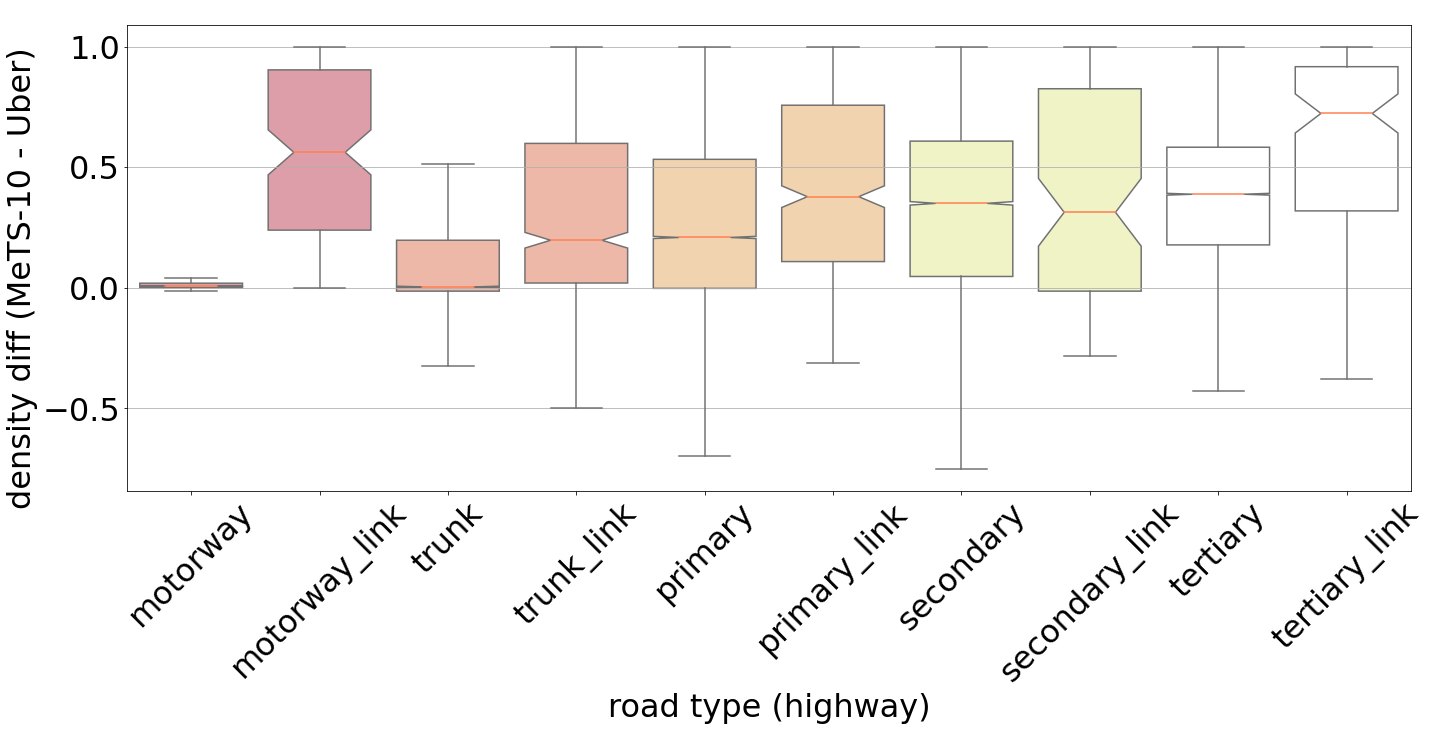

In [80]:
plt.rcParams["axes.labelsize"] = 32
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(
    gdf_ut_counts_merged[(gdf_ut_counts_merged["in_bb"] == True) & ([simplified_filter(hw) for hw in gdf_ut_counts_merged["highway"]])],
    x="highway",
    y="density_diff",
    notch=True,
    sym="",
    palette=osm_color_palette(),
    medianprops={"color": "coral"},
    ax=ax,
)
ax.tick_params(axis="x", which="major", labelsize=32, rotation=45)
ax.tick_params(axis="y", which="major", labelsize=32)
ax.grid(axis="y")
ax.set(xlabel='road type (highway)',
       ylabel='density diff (MeTS-10 - Uber)    ')
plt.savefig("London_Uber_density_diff_barplot.pdf")

## Density histograms and stats

In [48]:
# instead of un/pivoting.....
ucounts["src"] = "u"
tcounts["src"] = "t"
counts_all = pd.concat([ucounts.rename(columns={"speed_kph_mean": "speed"}), tcounts.rename(columns={"median_speed_kph": "speed"})])
counts_all = counts_all.merge(gdf_edges, on=["u", "v", "gkey"])
counts_all["sort_key"] = [highway_ordering.index(hw) for hw in counts_all["highway"]]
counts_all = counts_all.sort_values("sort_key")
counts_all["matching"] = [(u, v, gkey) in t_ids for u, v, gkey in zip(counts_all["u"], counts_all["v"], counts_all["gkey"])]

## Density histogram for both

In [49]:
def plot_and_stats(df, density_attr, speed_attr):
    fig, axs = plt.subplots(2, figsize=(10, 5), tight_layout=True)
    axs[0].hist(df[density_attr], bins=10)
    axs[0].set_xlabel(density_attr)
    axs[1].hist(df[speed_attr], bins=48)
    axs[1].set_xlabel(speed_attr)
    df_gr = df.groupby("highway").agg(
        {
            density_attr: ["count", "mean", "median", "min", "max", "std"],
            speed_attr: ["mean", "median", "min", "max", "std"],
            "speed_kph": ["mean", "median", "min", "max", "std"],
            "length_meters": ["mean", "median", "min", "max", "std"],
        }
    )
    df_gr["sort_key"] = [highway_ordering.index(hw) for hw in df_gr.reset_index()["highway"]]
    display(df_gr.sort_values("sort_key"))

### density over full area

<AxesSubplot:xlabel='highway', ylabel='density'>

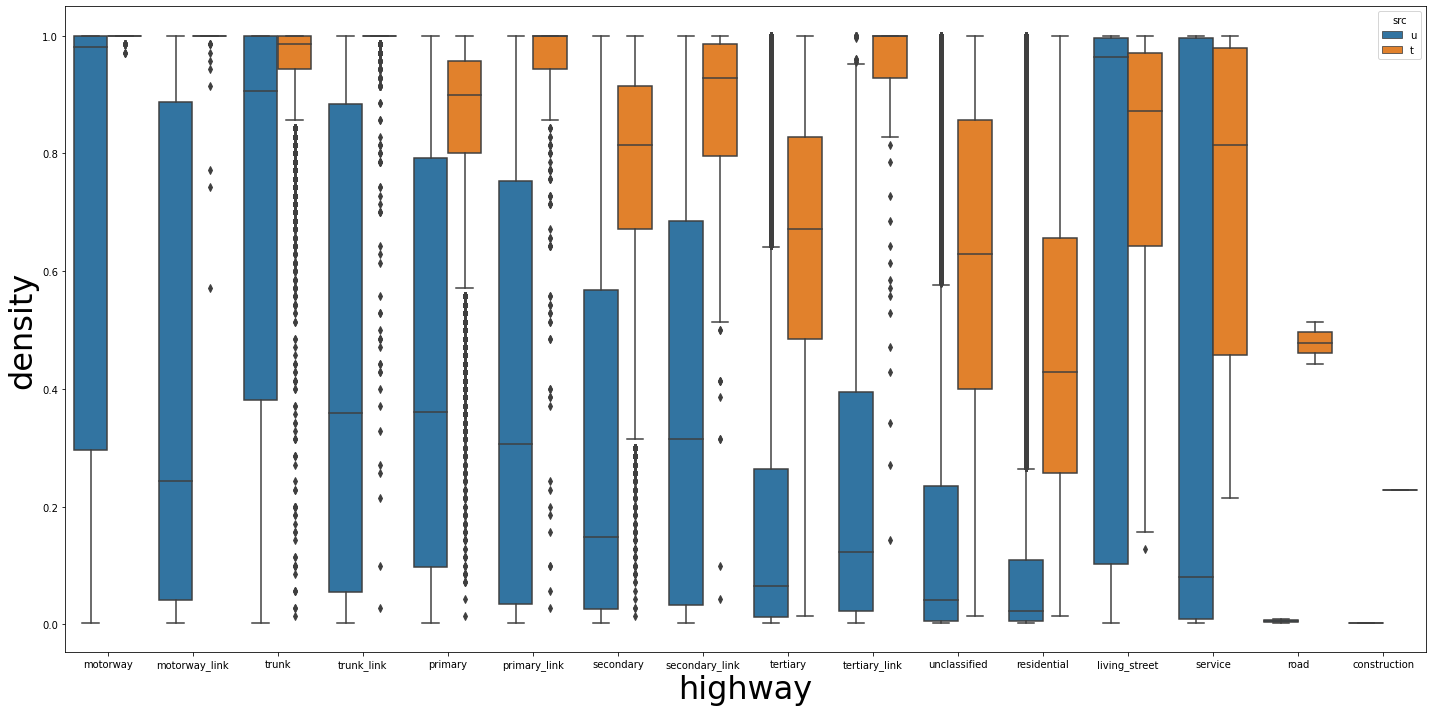

In [50]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(counts_all, x="highway", y="density", hue="src", ax=ax)
# TODO this looks fishy: motorway over full areay t should have 0 for everything ourside of the box - outer join?!

#### full area Uber

density_u                                                    \
                   count      mean    median       min       max       std   
highway                                                                      
motorway            1520  0.685371  0.977419  0.000000  1.000000  0.395226   
motorway_link        894  0.397647  0.169355  0.000000  1.000000  0.404230   
trunk              17347  0.671282  0.877419  0.000000  1.000000  0.379649   
trunk_link          1600  0.411879  0.270968  0.000000  1.000000  0.391172   
primary            62005  0.417863  0.322581  0.000000  1.000000  0.361080   
primary_link         907  0.353409  0.196774  0.000000  1.000000  0.360221   
secondary          28003  0.267545  0.093548  0.000000  1.000000  0.330228   
secondary_link       135  0.332521  0.148387  0.000000  1.000000  0.358721   
tertiary           59977  0.171760  0.038710  0.000000  1.000000  0.267833   
tertiary_link        257  0.233061  0.093548  0.000000  1.000000  0.305515   
unclassified       12447  0.145992  0.012903  0.000000  1.000000  0.261062   
residential        49110  0.093455  0.009677  0.000000  1.000000  0.198534   
living_street         58  0.564071  0.930645  0.000000  1.000000  0.469512   
service               44  0.283944  0.016129  0.000000  1.000000  0.419780   
cycleway               1  0.000000  0.000000  0.000000  0.000000       NaN   
road                   2  0.006452  0.006452  0.003226  0.009677  0.004562   
construction           1  0.003226  0.003226  0.003226  0.003226       NaN   

               speed_kph_mean                                    ...  \
                         mean     median        min         max  ...   
highway                                                          ...   
motorway            90.215723  97.694180   0.000000  118.923789  ...   
motorway_link       63.267339  67.699301   5.901450  125.567144  ...   
trunk               40.021699  35.797354   1.546576  117.539756  ...   
trunk_link          42.301602  41.762373   2.129157   98.499655  ...   
primary             34.562827  34.015010   1.115273  123.381660  ...   
primary_link        30.065613  27.582478   2.743925   78.770756  ...   
secondary           34.529969  34.016620   1.599684   88.515309  ...   
secondary_link      25.791116  23.010343   4.919752   65.060788  ...   
tertiary            33.126937  32.746850   0.946292   93.501045  ...   
tertiary_link       29.747168  28.064476   4.763646   71.689660  ...   
unclassified        27.241709  26.153384   0.804670   79.462772  ...   
residential         25.459864  25.143523   0.383023   97.892934  ...   
living_street       21.564505  21.639186   5.351056   32.198065  ...   
service             34.603639  30.517914   9.622244   71.601146  ...   
cycleway                  NaN        NaN        NaN         NaN  ...   
road                19.037688  19.037688  17.152346   20.923029  ...   
construction        27.117379  27.117379  27.117379   27.117379  ...   

               speed_kph                         length_meters              \
                  median   min    max        std          mean      median   
highway                                                                      
motorway           112.7  48.3  112.7   8.326811    691.094745  286.228458   
motorway_link      112.7  48.3  112.7  14.159793    293.250241  182.611128   
trunk               48.3  30.0  112.7  21.493107    144.082743   63.234518   
trunk_link          72.8  30.0  112.7  21.583534    178.825553   97.061468   
primary             48.3   8.0  112.7  13.477665     91.039320   54.977092   
primary_link        48.3  32.2  112.7  13.932180     83.984550   48.807661   
secondary           48.3  30.0  112.7  14.177788    104.470267   63.180663   
secondary_link      48.3  32.2   96.6  14.246406     54.725302   33.632698   
tertiary            46.2  16.1  112.7  12.946014    104.885872   68.485485   
tertiary_link       52.0  32.2  112.7  12.721544     77.289128   47.594571   

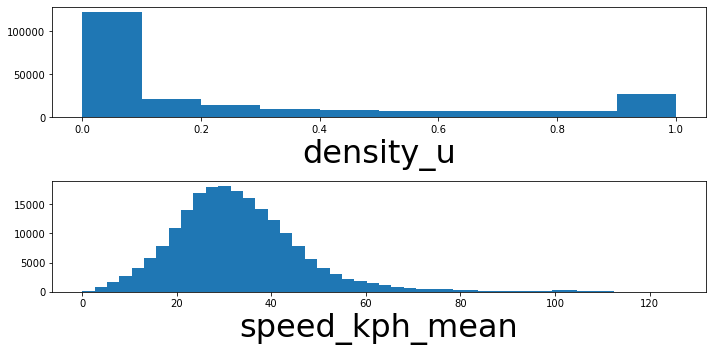

In [51]:
plot_and_stats(gdf_ut_counts_merged, "density_u", "speed_kph_mean")

#### density full area t4c

density_t                                                    \
                   count      mean    median       min       max       std   
highway                                                                      
motorway            1520  0.204380  0.000000  0.000000  1.000000  0.403105   
motorway_link        894  0.138495  0.000000  0.000000  1.000000  0.344200   
trunk              17347  0.655871  0.942857  0.000000  1.000000  0.447418   
trunk_link          1600  0.472527  0.000000  0.000000  1.000000  0.490974   
primary            62005  0.472567  0.657143  0.000000  1.000000  0.441295   
primary_link         907  0.525626  0.842857  0.000000  1.000000  0.476560   
secondary          28003  0.408104  0.428571  0.000000  1.000000  0.407637   
secondary_link       135  0.544444  0.785714  0.000000  1.000000  0.436855   
tertiary           59977  0.311233  0.000000  0.000000  1.000000  0.360003   
tertiary_link        257  0.483157  0.528571  0.000000  1.000000  0.477061   
unclassified       12447  0.368761  0.314286  0.000000  1.000000  0.364565   
residential        49110  0.355252  0.314286  0.000000  1.000000  0.303710   
living_street         58  0.706897  0.871429  0.000000  1.000000  0.335225   
service               44  0.307792  0.000000  0.000000  1.000000  0.399994   
cycleway               1  0.000000  0.000000  0.000000  0.000000       NaN   
road                   2  0.478571  0.478571  0.442857  0.514286  0.050508   
construction           1  0.228571  0.228571  0.228571  0.228571       NaN   

               median_speed_kph                                    ...  \
                           mean     median        min         max  ...   
highway                                                            ...   
motorway              78.687073  86.764706  13.725490  113.098039  ...   
motorway_link         64.277359  68.588235  16.666667  105.921569  ...   
trunk                 29.750236  26.465686   0.156863  115.294118  ...   
trunk_link            38.010689  34.843137   2.666667  105.647059  ...   
primary               28.163313  26.901961   0.078431  117.882353  ...   
primary_link          30.515067  26.823529   3.294118   77.088235  ...   
secondary             28.660329  27.627451   0.098039  119.764706  ...   
secondary_link        24.154560  21.882353   4.823529   83.294118  ...   
tertiary              28.833636  27.764706   0.156863  118.588235  ...   
tertiary_link         34.349917  28.808824   6.176471   75.117647  ...   
unclassified          23.072209  21.176471   0.156863  116.705882  ...   
residential           24.415067  23.764706   0.117647  119.529412  ...   
living_street         17.485572  17.372549   1.882353   30.588235  ...   
service               21.893189  18.823529   9.137255   70.117647  ...   
cycleway                    NaN        NaN        NaN         NaN  ...   
road                  25.784314  25.784314  25.529412   26.039216  ...   
construction          11.764706  11.764706  11.764706   11.764706  ...   

               speed_kph                         length_meters              \
                  median   min    max        std          mean      median   
highway                                                                      
motorway           112.7  48.3  112.7   8.326811    691.094745  286.228458   
motorway_link      112.7  48.3  112.7  14.159793    293.250241  182.611128   
trunk               48.3  30.0  112.7  21.493107    144.082743   63.234518   
trunk_link          72.8  30.0  112.7  21.583534    178.825553   97.061468   
primary             48.3   8.0  112.7  13.477665     91.039320   54.977092   
primary_link        48.3  32.2  112.7  13.932180     83.984550   48.807661   
secondary           48.3  30.0  112.7  14.177788    104.470267   63.180663   
secondary_link      48.3  32.2   96.6  14.246406     54.725302   33.632698   
tertiary            46.2  16.1  112.7  12.946014    104.885872   68.485485   
tertiary_link       52.0  32.2  112.7

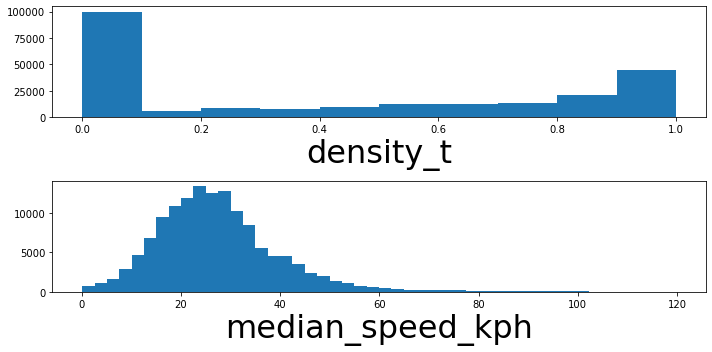

In [52]:
plot_and_stats(gdf_ut_counts_merged, "density_t", "median_speed_kph")

### density within bounding box

<AxesSubplot:xlabel='highway', ylabel='density'>

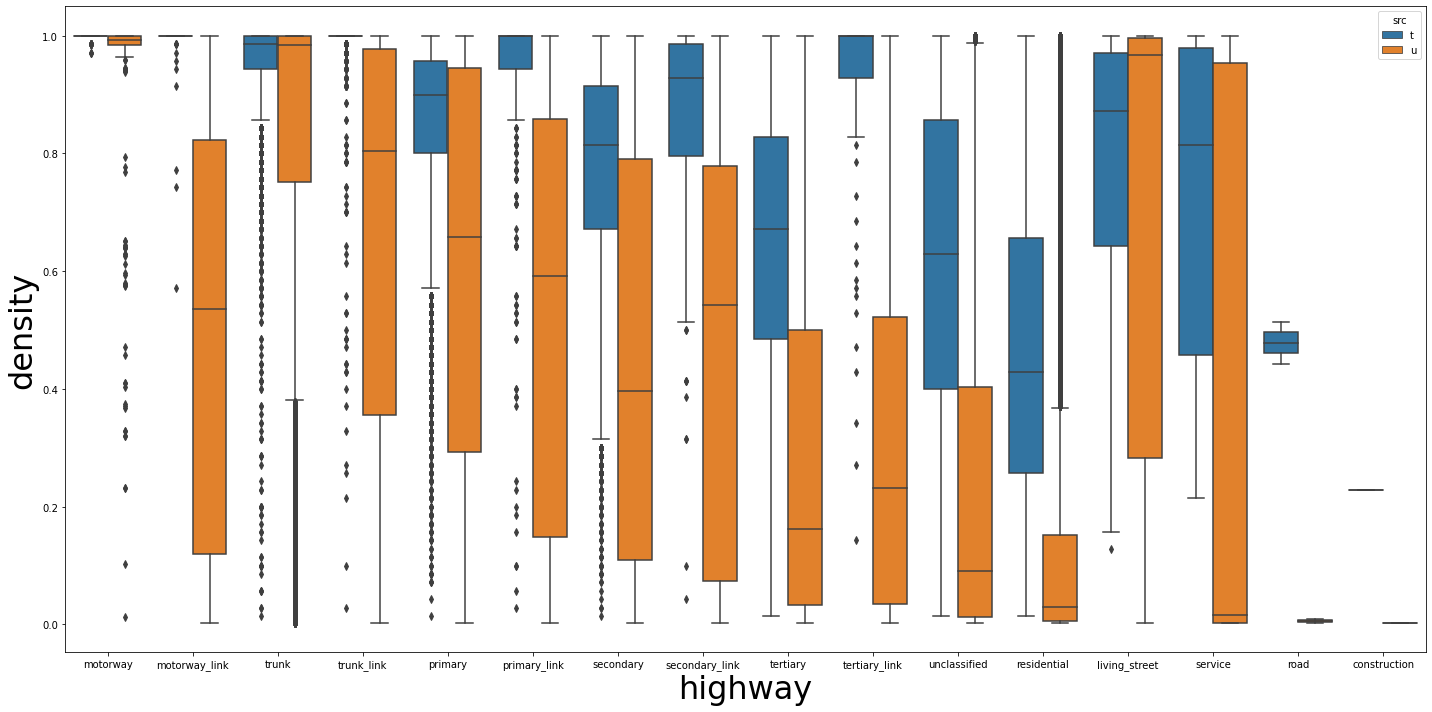

In [53]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(counts_all[counts_all["in_bb"] == True], x="highway", y="density", hue="src", ax=ax)

#### density bounding box Uber

density_u                                                    \
                   count      mean    median       min       max       std   
highway                                                                      
motorway             311  0.922539  0.993548  0.000000  1.000000  0.195011   
motorway_link        125  0.447174  0.438710  0.000000  1.000000  0.368570   
trunk              11928  0.824869  0.983871  0.000000  1.000000  0.276299   
trunk_link           779  0.644751  0.790323  0.000000  1.000000  0.359108   
primary            33917  0.594572  0.651613  0.000000  1.000000  0.343296   
primary_link         511  0.502828  0.561290  0.000000  1.000000  0.365839   
secondary          14738  0.437100  0.367742  0.000000  1.000000  0.354794   
secondary_link        88  0.450916  0.474194  0.000000  1.000000  0.367508   
tertiary           28749  0.277513  0.135484  0.000000  1.000000  0.316090   
tertiary_link        134  0.323495  0.201613  0.000000  1.000000  0.339122   
unclassified        7506  0.212541  0.048387  0.000000  1.000000  0.302015   
residential        37277  0.117251  0.016129  0.000000  1.000000  0.220283   
living_street         53  0.617225  0.945161  0.000000  1.000000  0.456326   
service               19  0.277759  0.003226  0.000000  1.000000  0.437350   
road                   2  0.006452  0.006452  0.003226  0.009677  0.004562   
construction           1  0.003226  0.003226  0.003226  0.003226       NaN   

               speed_kph_mean                                    ...  \
                         mean     median        min         max  ...   
highway                                                          ...   
motorway            91.764666  99.389620  24.347705  114.671912  ...   
motorway_link       60.523462  66.417462   7.604131   92.821903  ...   
trunk               34.577017  32.832145   1.546576  117.539756  ...   
trunk_link          34.642868  32.865941   2.129157   88.722914  ...   
primary             30.788610  31.034513   1.115273  123.381660  ...   
primary_link        27.880262  24.387938   2.743925   66.697487  ...   
secondary           30.605694  30.763339   1.599684   83.114364  ...   
secondary_link      23.009749  21.939328   4.919752   63.454667  ...   
tertiary            29.832051  29.734166   1.087914   77.388333  ...   
tertiary_link       28.973165  26.515486   4.763646   67.650216  ...   
unclassified        23.996989  23.503606   0.804670   62.815759  ...   
residential         24.476702  24.394376   0.383023   97.892934  ...   
living_street       21.436969  21.587687   5.351056   32.198065  ...   
service             37.917123  30.020628   9.622244   69.748796  ...   
road                19.037688  19.037688  17.152346   20.923029  ...   
construction        27.117379  27.117379  27.117379   27.117379  ...   

               speed_kph                         length_meters              \
                  median   min    max        std          mean      median   
highway                                                                      
motorway           112.7  64.4  112.7  13.188930    829.658717  358.131196   
motorway_link      112.7  48.3  112.7  17.969739    429.675056  343.916990   
trunk               48.3  32.2  112.7  12.396002    102.939954   57.220761   
trunk_link          64.4  30.0  112.7  14.909323    112.860609   57.805269   
primary             48.3   8.0   96.6   9.153835     74.228942   50.743193   
primary_link        48.3  32.2   80.5  11.434111     70.974658   42.865649   
secondary           48.3  30.0  112.7   9.757487     86.668050   58.832532   
secondary_link      48.1  32.2   80.5   9.483404     44.259646   29.581469   
tertiary            46.2  16.1   96.6   9.234692     95.410438   66.778076   
tertiary_link       48.3  32.2   96.6  11.486504     75.487651   46.016084   
unclassified        32.2   8.0   96.6   7.274042     85.562213   56.155105   
residential         32.2   8.0   80.5   5.346779     99.729013   75.209

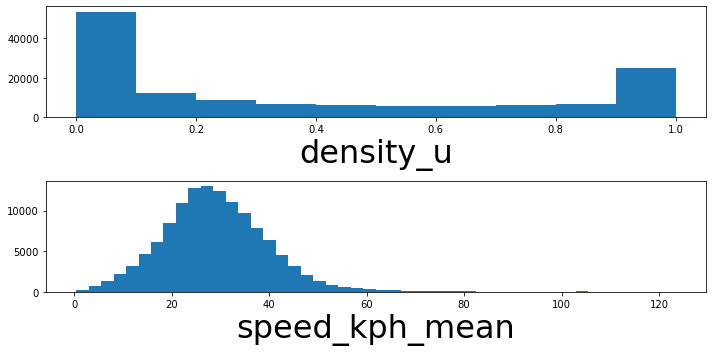

In [54]:
plot_and_stats(gdf_ut_counts_merged[gdf_ut_counts_merged["in_bb"] == True], "density_u", "speed_kph_mean")

#### density bounding box t4c

density_t                                                    \
                   count      mean    median       min       max       std   
highway                                                                      
motorway             311  0.998898  1.000000  0.971429  1.000000  0.004305   
motorway_link        125  0.990514  1.000000  0.571429  1.000000  0.049585   
trunk              11928  0.953840  0.985714  0.014286  1.000000  0.083050   
trunk_link           779  0.970530  1.000000  0.028571  1.000000  0.107172   
primary            33917  0.863863  0.900000  0.014286  1.000000  0.134042   
primary_link         511  0.932961  1.000000  0.028571  1.000000  0.150603   
secondary          14738  0.775324  0.814286  0.000000  1.000000  0.176090   
secondary_link        88  0.835227  0.928571  0.042857  1.000000  0.219728   
tertiary           28749  0.649304  0.671429  0.000000  1.000000  0.225535   
tertiary_link        134  0.926652  1.000000  0.142857  1.000000  0.154943   
unclassified        7506  0.611507  0.628571  0.014286  1.000000  0.268231   
residential        37277  0.467976  0.428571  0.000000  1.000000  0.262217   
living_street         53  0.773585  0.871429  0.128571  1.000000  0.265706   
service               19  0.712782  0.814286  0.214286  1.000000  0.278394   
road                   2  0.478571  0.478571  0.442857  0.514286  0.050508   
construction           1  0.228571  0.228571  0.228571  0.228571       NaN   

               median_speed_kph                                    ...  \
                           mean     median        min         max  ...   
highway                                                            ...   
motorway              78.687073  86.764706  13.725490  113.098039  ...   
motorway_link         64.277359  68.588235  16.666667  105.921569  ...   
trunk                 29.750236  26.465686   0.156863  115.294118  ...   
trunk_link            38.010689  34.843137   2.666667  105.647059  ...   
primary               28.161996  26.901961   0.078431  117.882353  ...   
primary_link          30.515067  26.823529   3.294118   77.088235  ...   
secondary             28.659742  27.627451   0.098039  119.764706  ...   
secondary_link        24.154560  21.882353   4.823529   83.294118  ...   
tertiary              28.833636  27.764706   0.156863  118.588235  ...   
tertiary_link         34.349917  28.808824   6.176471   75.117647  ...   
unclassified          23.072209  21.176471   0.156863  116.705882  ...   
residential           24.413896  23.764706   0.117647  119.529412  ...   
living_street         17.485572  17.372549   1.882353   30.588235  ...   
service               21.893189  18.823529   9.137255   70.117647  ...   
road                  25.784314  25.784314  25.529412   26.039216  ...   
construction          11.764706  11.764706  11.764706   11.764706  ...   

               speed_kph                         length_meters              \
                  median   min    max        std          mean      median   
highway                                                                      
motorway           112.7  64.4  112.7  13.188930    829.658717  358.131196   
motorway_link      112.7  48.3  112.7  17.969739    429.675056  343.916990   
trunk               48.3  32.2  112.7  12.396002    102.939954   57.220761   
trunk_link          64.4  30.0  112.7  14.909323    112.860609   57.805269   
primary             48.3   8.0   96.6   9.153835     74.228942   50.743193   
primary_link        48.3  32.2   80.5  11.434111     70.974658   42.865649   
secondary           48.3  30.0  112.7   9.757487     86.668050   58.832532   
secondary_link      48.1  32.2   80.5   9.483404     44.259646   29.581469   
tertiary            46.2  16.1   96.6   9.234692     95.410438   66.778076   
tertiary_link       48.3  32.2   96.6  11.486504     75.487651   46.016084   
unclassified        32.2   8.0   96.6   7.274042     85.562213   56.155105   
residential         32.2   8.0   

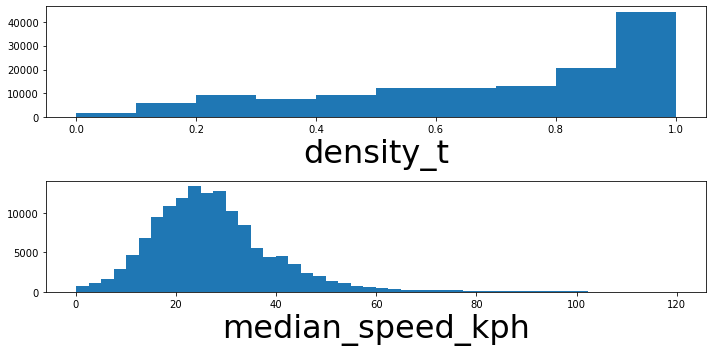

In [55]:
plot_and_stats(gdf_ut_counts_merged[gdf_ut_counts_merged["in_bb"] == True], "density_t", "median_speed_kph")

### Density and speeds for matched edges

In [56]:
# more fishy...

In [57]:
counts_all[(counts_all["matching"] == True) & ((counts_all["src"] == "t"))]

,u,v,gkey,count,speed,density,src,mean_volume,osmid,speed_kph,...,name,node_id,x_u,y_u,node_id_v,x_v,y_v,in_bb,sort_key,matching
163948,250763350,250763349,250763350_250763349_23189332,70,77.647059,1.000000,t,7.129762,23189332,112.7,...,,250763350,-0.261448,51.278116,250763349,-0.261663,51.278422,True,0,True
163946,250763349,10815141,250763349_10815141_23189331,70,76.303922,1.000000,t,31.992857,23189331,112.7,...,,250763349,-0.261663,51.278422,10815141,-0.264103,51.281215,True,0,True
163944,250763301,250763300,250763301_250763300_23189326,70,102.078431,1.000000,t,8.648810,23189326,112.7,...,,250763301,-0.261389,51.278508,250763300,-0.261165,51.278170,True,0,True
163942,250763300,206224677,250763300_206224677_682680247,70,92.019608,1.000000,t,345.532143,682680247,112.7,...,,250763300,-0.261165,51.278170,206224677,-0.202351,51.258249,True,0,True
163940,250763225,250763127,250763225_250763127_23189309,70,79.980392,1.000000,t,58.841667,23189309,112.7,...,,250763225,-0.264521,51.281541,250763127,-0.272675,51.287135,True,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269675,2146369239,25497323,2146369239_25497323_204645299,15,18.823529,0.214286,t,1.800000,204645299,32.2,...,Grand Avenue,2146369239,-0.101576,51.519625,25497323,-0.101636,51.519738,True,13,True
226271,1315138906,1315139135,1315138906_1315139135_116717555,38,18.823529,0.542857,t,1.995614,116717555,32.2,...,,1315138906,-0.179852,51.545585,1315139135,-0.179988,51.545638,True,13,True
297620,4346458075,4376910559,4346458075_4376910559_436772431,31,25.529412,0.442857,t,4.854839,436772431,52.8,...,,4346458075,-0.081328,51.630826,4376910559,-0.081751,51.630805,True,15,True
297893,4376910562,4346458075,4376910562_4346458075_439987200,36,26.039216,0.514286,t,4.250000,439987200,52.8,...,,4376910562,-0.080931,51.630883,4346458075,-0.081328,51.630826,True,15,True


In [58]:
counts_all[(counts_all["matching"] == True) & ((counts_all["src"] == "u"))]

,u,v,gkey,count,speed,density,src,mean_volume,osmid,speed_kph,...,name,node_id,x_u,y_u,node_id_v,x_v,y_v,in_bb,sort_key,matching
163947,250763350,250763349,250763350_250763349_23189332,310,108.950709,1.000000,u,NaN,23189332,112.7,...,,250763350,-0.261448,51.278116,250763349,-0.261663,51.278422,True,0,True
163945,250763349,10815141,250763349_10815141_23189331,310,108.743104,1.000000,u,NaN,23189331,112.7,...,,250763349,-0.261663,51.278422,10815141,-0.264103,51.281215,True,0,True
163943,250763301,250763300,250763301_250763300_23189326,310,102.259073,1.000000,u,NaN,23189326,112.7,...,,250763301,-0.261389,51.278508,250763300,-0.261165,51.278170,True,0,True
163941,250763300,206224677,250763300_206224677_682680247,310,107.029157,1.000000,u,NaN,682680247,112.7,...,,250763300,-0.261165,51.278170,206224677,-0.202351,51.258249,True,0,True
163939,250763225,250763127,250763225_250763127_23189309,310,110.085293,1.000000,u,NaN,23189309,112.7,...,,250763225,-0.264521,51.281541,250763127,-0.272675,51.287135,True,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269674,2146369239,25497323,2146369239_25497323_204645299,1,64.244853,0.003226,u,NaN,204645299,32.2,...,Grand Avenue,2146369239,-0.101576,51.519625,25497323,-0.101636,51.519738,True,13,True
226270,1315138906,1315139135,1315138906_1315139135_116717555,1,17.594914,0.003226,u,NaN,116717555,32.2,...,,1315138906,-0.179852,51.545585,1315139135,-0.179988,51.545638,True,13,True
297892,4376910562,4346458075,4376910562_4346458075_439987200,1,17.152346,0.003226,u,NaN,439987200,52.8,...,,4376910562,-0.080931,51.630883,4346458075,-0.081328,51.630826,True,15,True
297619,4346458075,4376910559,4346458075_4376910559_436772431,3,20.923029,0.009677,u,NaN,436772431,52.8,...,,4346458075,-0.081328,51.630826,4376910559,-0.081751,51.630805,True,15,True


<AxesSubplot:xlabel='highway', ylabel='density'>

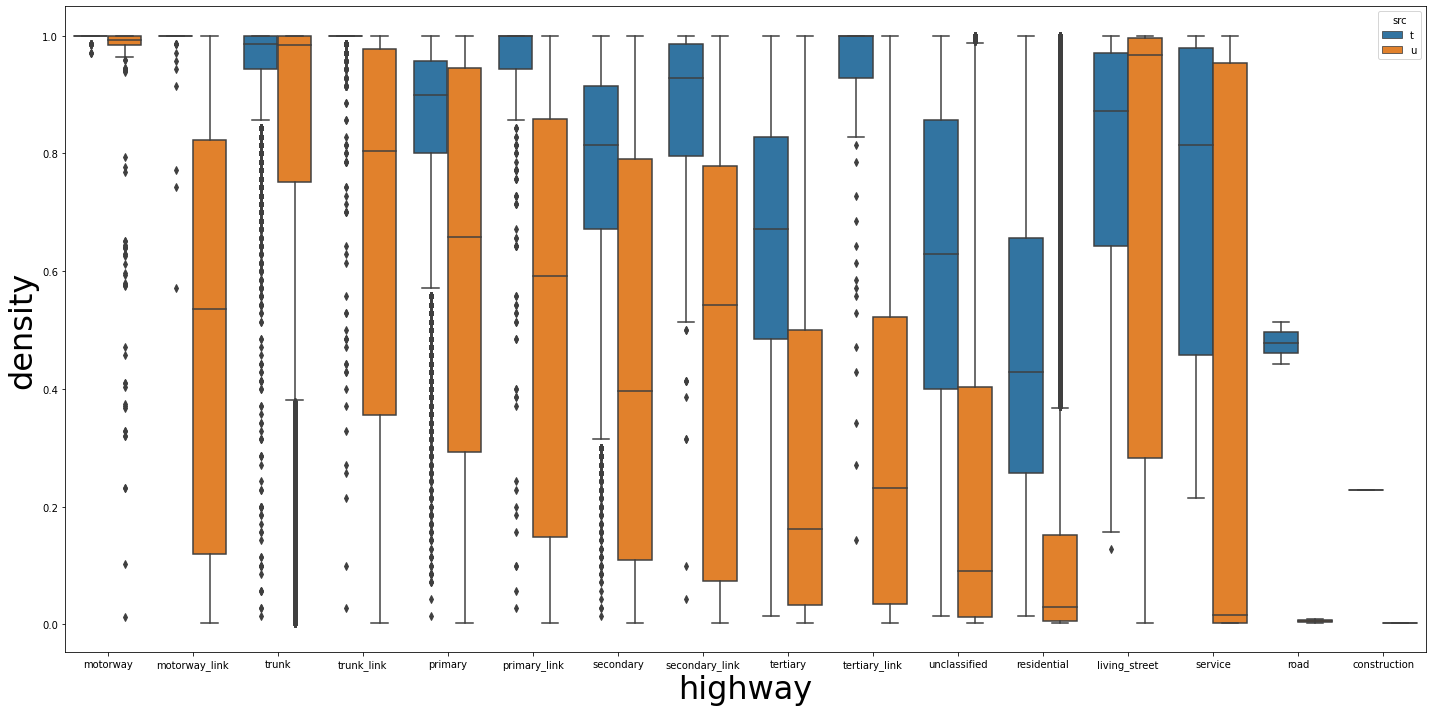

In [59]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(counts_all[counts_all["matching"] == True], x="highway", y="density", hue="src", ax=ax)

<AxesSubplot:xlabel='highway', ylabel='speed'>

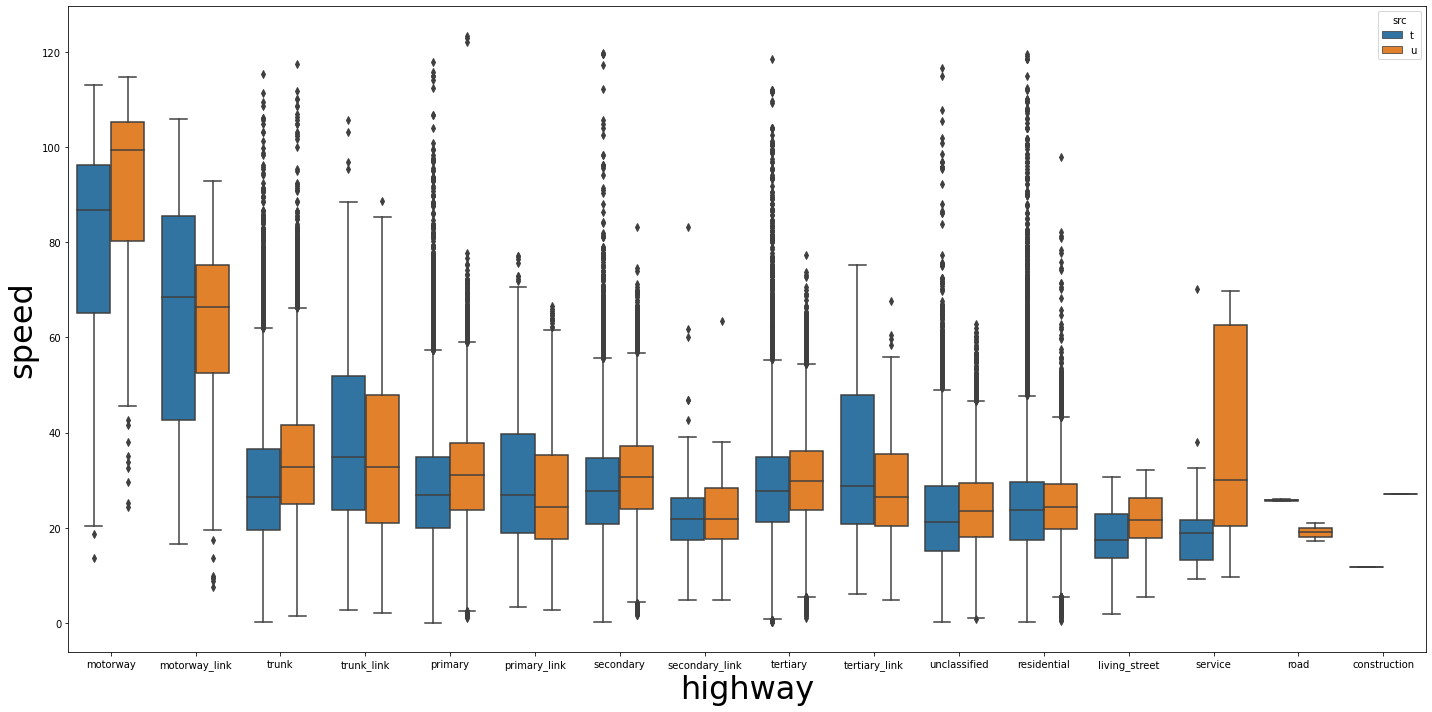

In [60]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(counts_all[counts_all["matching"] == True], x="highway", y="speed", hue="src", ax=ax)